# Semianr 9 - Applied Quantitative Logistics

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Hub Location Allocation

In [2]:
def hubLocation():
    
    ### Customer Data
    xc = [74, 146, 41, 70, 176, 60, 1, 54, 149, 60, 132, 199, 2,
          31, 176, 127, 71, 78, 71, 151, 145, 37, 157, 139, 27,
          138, 97, 104, 137, 83, 67, 196, 152, 149, 148, 56, 64, 31, 31, 52]
    
    yc = [79, 95, 149, 185, 106, 175, 144, 63, 165, 81, 164, 132, 110, 118,
          29, 13, 52, 158, 73, 172, 103, 172, 69, 90, 104, 102, 70, 162, 192,
          195, 178, 153, 41, 57, 67, 5, 83, 146, 122, 2]
    
    d = [20, 15, 99, 32, 12, 8, 86, 26, 56, 38, 27, 15, 87, 83, 94, 34, 79,
         56, 10, 46, 99, 67, 43, 84, 45, 81, 83, 89, 30, 78, 78, 21, 75, 93,
         70, 16, 20, 48, 88, 54]
    
    N = len(xc)     # Number of customers
    
    ### Service Center Data
    xs = [2, 52, 166, 126, 100, 165, 198, 76, 76, 105, 44,
          125, 82, 25, 5, 58, 74, 75, 171, 51]
    
    ys = [126, 196, 104, 28, 4, 32, 122, 35, 123, 45, 2, 158,
          25, 101, 109, 74, 102, 159, 42, 100]
    
    M = len(xs)     # Number of potential service centers
    
    D = np.zeros([N-1, M-1])
    for i in range(N-1):
        for j in range(M-1):
            D[i][j] = math.sqrt(abs(xc[i]-xs[j] + yc[i]-ys[j]))
    
    model = {'N': N,
             'M': M,
             'xc': xc,
             'yc': yc,
             'xs': xs,
             'ys': ys,
             'd': d,
             'D': D}
    
    return model

In [3]:
# model = hubLocation()

In [4]:
# Distance between customer 4 and service cemter 8

# model['D'][4][8]

### Create Random Solution

In [5]:
def createRandomSolution(model):
    M = model['M']
    f = list(np.random.randint(0, 2, M))
    
    return f


### Cost Function

In [6]:
def myCost(f, model):
    
    global NFE
    
    if pd.isna(NFE):
        NFE = 0
        
    NFE += 1
    
    if (np.all(np.array(f) == 0)):
        z = math.inf
        return z
    
    N = model['N']
    M = model['M']
    D = model['D']
    
    D_min = np.zeros(N)
    
    for i in range(0, N-1):
        D_temp = []
        for j in range(0, M-1):
            if f[j] == 1:
                D_temp.append(D[i][j])
                
        D_min[i] = min(D_temp)
        
    z = sum(np.array(model['d']) * np.array(D_min))
    
    return z

### Sorting Population

In [7]:
# Sort the population and cost (based on the cost)
def pop_sort(p, c):
    li = []
    for i in range(len(c)):
        li.append([c[i],i])
        
    li.sort()
    sort_index = []
    
    for x in li:
        sort_index.append(x[1])
    
    positions, cost = [], []
    for i in sort_index:
        positions.append(p[i])
        cost.append(c[i])
        
    return positions, cost

### Roullete Wheel Selection

In [8]:
def rouletteWheelSelection(p):
    r = random.random()
    
    c = np.cumsum(p)
    
    indexes = [
    index for index in range(len(c))
    if c[index] > r
    ]
    
    return indexes[0]

### Crossover

In [9]:
# Uniform Crossover is better than double point crossover better than single point crossover

# Single point crossover
def singlePoint_crossover(x1, x2):
    index = np.random.randint(1, len(x1)-1, size=1)[0]

    y1 = np.concatenate((x1[:index], x2[index:]))
    y2 = np.concatenate((x2[:index], x1[index:]))
    return y1, y2

# Double Point Crossover
def doublePoint_crossover(x1, x2):
    ind = np.sort(np.random.choice(range(1, len(x1)-1), size=2, replace=False))
    index1, index2 = ind[0], ind[1]

    y1 = np.concatenate((x1[:index1], x2[index1:index2], x1[index2:]))
    y2 = np.concatenate((x2[:index1], x1[index1:index2], x2[index2:]))
    return y1, y2

# Uniform Crossover
def uniform_crossover(x1, x2):
    alpha = list(np.random.randint(2, size=len(x1)))

    y1 = list(np.multiply(alpha, x1) + (1-np.array(alpha)) * np.array(x2))
    y2 = list(np.multiply(alpha, x2) + (1-np.array(alpha)) * np.array(x1))
    
    return y1, y2

def CrossOver(x1, x2):
    
    pSinglePoint = 0.1
    pDoublePoint = 0.2
    pUniform = 1-pSinglePoint-pDoublePoint
    
    METHOD = rouletteWheelSelection([pSinglePoint, pDoublePoint, pUniform])

    if METHOD == 0:
        y1, y2 = singlePoint_crossover(x1, x2)
    elif METHOD == 1:
        y1, y2 = doublePoint_crossover(x1, x2)
    elif METHOD == 2:
        y1, y2 = uniform_crossover(x1, x2)
    
    return y1, y2

### Mutation

In [10]:
def Mutation(x):
    index = int(np.random.randint(0, len(x), size=1))
    
    y = x.copy()
    
    y[index] = 1-x[index]
    
    return y

### GA Algorithm

In [11]:
### Problem Parameters Definition ###

model = hubLocation()

nVar = model['M']       # Number of decision variables

global NFE
NFE = 0

### GA Parameters ###
maxIt = 75     # Maximum numner of iterations
nPop = 20       # Population size 

pc = 0.8                   # Crossover percentage
nc = 2*round(pc*nPop/2)    # Number of offsprings (parents)

pm = 0.3                   # Mutation percentage
nm = round(pm*nPop)        # Number of mutants2 = unifrnd(0,2 = unifrnd(0,

### Initialization ###
pop, costs = [], []

for i in range(0, nPop):
    pop.append(createRandomSolution(model))
    costs.append(myCost(pop[i], model))

# Sort the population and costs
pop, costs = pop_sort(pop, costs)

#  Store the best solution
bestSolution = [pop[0]]

# Array to hold best cost values
bestCosts = [costs[0]]

# Store the NFE into the array
nfe = [NFE]

### Main Loop ###
for it in range(1, maxIt):
    
    # Crossover
    popc, popc_cost = [], []
    for k in range(1, int(nc/2)):
        
        # Select parent indices
        rand1 = int(np.random.randint(nPop, size=1))
        rand2 = int(np.random.randint(nPop, size=1))
        
        # Select parents
        p1 = pop[rand1]
        p2 = pop[rand2]
        
        # Apply crossover
#         y1, y2 = singlePoint_crossover(p1, p2)
#         y1, y2 = doublePoint_crossover(p1, p2)
#         y1, y2 = uniform_crossover(p1, p2)

        y1, y2 = CrossOver(p1, p2)
        
        # Store the offspring after crossover
        popc.append(y1)
        popc.append(y2)
        
        # Evaluate the offspring
        popc_cost.append(myCost(y1, model))
        popc_cost.append(myCost(y2, model))
        
    # Mutation
    popm, popm_cost = [], []
    for k in range(1, nm):
        
        # Select parent
        rand = int(np.random.randint(nPop, size=1))
        p = pop[rand]
        
        # Apply Mutation
        popm.append(Mutation(p))
        
        # Evaluate the offspring
        popm_cost.append(myCost(popm[-1], model))
        
    # Create merged population
    pop = pop + popm + popc
    costs = costs + popm_cost + popc_cost
    
    # sort the whole population
    pop, costs = pop_sort(pop, costs)
    
    # Truncation
    pop = pop[:nPop]
    costs = costs[:nPop]
    
    # Store the best solution
    bestSolution.append(pop[0])
    
    # Store the best cost
    bestCosts.append(costs[0])
    
    # Append NFE to the array
    nfe.append(NFE)
    
#     if bestCosts[-2] == 0:
#         break
        
    print(f'Iteration {it} : NFE = {nfe[-1]}, Best Cost = {bestCosts[it]}')

Iteration 1 : NFE = 39, Best Cost = 4872.97851444726
Iteration 2 : NFE = 58, Best Cost = 4859.535798693046
Iteration 3 : NFE = 77, Best Cost = 4473.548982313854
Iteration 4 : NFE = 96, Best Cost = 4473.548982313854
Iteration 5 : NFE = 115, Best Cost = 4473.548982313854
Iteration 6 : NFE = 134, Best Cost = 4473.548982313854
Iteration 7 : NFE = 153, Best Cost = 4473.548982313854
Iteration 8 : NFE = 172, Best Cost = 4473.548982313854
Iteration 9 : NFE = 191, Best Cost = 4441.033043178897
Iteration 10 : NFE = 210, Best Cost = 4422.3796308633255
Iteration 11 : NFE = 229, Best Cost = 4343.318143645886
Iteration 12 : NFE = 248, Best Cost = 4343.318143645886
Iteration 13 : NFE = 267, Best Cost = 4343.318143645886
Iteration 14 : NFE = 286, Best Cost = 4330.33724863926
Iteration 15 : NFE = 305, Best Cost = 4251.275761421822
Iteration 16 : NFE = 324, Best Cost = 4251.275761421822
Iteration 17 : NFE = 343, Best Cost = 4251.275761421822
Iteration 18 : NFE = 362, Best Cost = 4232.622349106249
Iterat

### Results

Text(0, 0.5, 'Costs')

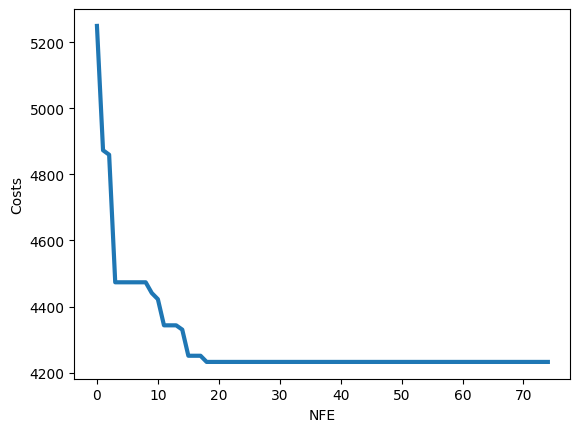

In [12]:
# Plot the result
plt.plot(bestCosts, linewidth = 3)
plt.xlabel('NFE')
plt.ylabel('Costs')

# HW6 - Applied Quantitative Logistics

Solve TSP problem with continues GA algorithm. The solution should be generated in continues values. Use all regular Crossover and Mutation. This type of problem solving has no interfere with permutaion problems.

Hint: Just before calculating the cost, you need to convert the solution into the permutation format. For example:

- Solution in continues format is: [0.111, 0,854, 0,234, 0.542, 0.01]
- The permutation format is: [2, 5, 3, 4, 1]

Instruction for submission:

- Please submit your solutions in (.ipynb) format to my email (msohrabi@hse.ru).

- Deadline: **April 28, 2023, 11:59 pm.**

- The subject of the email and file name: **[HW6_AQL]-YOUR_NAME**

In [13]:
def createRandomSolution(model):
    M = model['M']
    # Create continuous solition with float values from 0 to 1
    f = np.random.uniform(0, 1, size=M).round(4)

    return f

In [14]:
def myCost(f, model):
    
    global NFE
    
    if pd.isna(NFE):
        NFE = 0
        
    NFE += 1
    
    if (np.all(np.array(f) == 0)):
        z = math.inf
        return z
    
    N = model['N']
    M = model['M']
    D = model['D']
    
    # Convert continuous solutions to binary solutions
    f_array = np.array(f)
    sol = np.where(f_array > 0.5, 1, 0)
    
    D_min = np.zeros(N)
    
    for i in range(0, N-1):
        D_temp = []
        for j in range(0, M-1):
            if sol[j] == 1:
                D_temp.append(D[i][j])
                
        D_min[i] = min(D_temp)
        
    z = sum(np.array(model['d']) * np.array(D_min))
    
    return z

In [44]:
# Regular mutation functions
def swapMutation(solution):
    index1, index2 = np.random.choice(len(solution), size=2, replace=False)
    solution[index1], solution[index2] = solution[index2], solution[index1]
    return solution

def reversionMutation(solution):
    index1, index2 = np.random.choice(len(solution), size=2, replace=False)
    solution[min(index1, index2):max(index1, index2)+1] = solution[min(index1, index2):max(index1, index2)+1][::-1]
    return solution

def insertionMutation(solution):
    index1, index2 = np.random.choice(len(solution), size=2, replace=False)
    value = solution[index1]
    solution = np.delete(solution, index1)
    solution = np.insert(solution, index2, value)
    return solution

def Mutation(x):
    probabilities = [0.2, 0.3, 0.5]
    method_index = rouletteWheelSelection(probabilities)
    
    if method_index == 0:
        y = swapMutation(x)
    elif method_index == 1:
        y = reversionMutation(x)
    else:
        y = insertionMutation(x)
        
    return y


In [45]:
def genetic_algorithm(model, maxIt, nPop, pc, pm):
    # Define problem parameters
    nVar = model['M']
    global NFE
    NFE = 0
    
    # Initialize population and costs
    pop, costs = [], []
    for i in range(0, nPop):
        pop.append(createRandomSolution(model))
        costs.append(myCost(pop[i], model))
    
    # Sort the population and costs
    pop, costs = pop_sort(pop, costs)
    
    # Store the best solution
    bestSolution = [pop[0]]
    
    # Array to hold best cost values
    bestCosts = [costs[0]]
    
    # Array to hold average cost values
    avgCosts = [sum(costs)/nPop]
    
    # Store the NFE into the array
    nfe = [NFE]
    
    # Main Loop
    for it in range(1, maxIt+1):
        # Crossover
        popc, popc_cost = [], []
        for k in range(1, int(pc*nPop/2)):
            # Select parents
            rand1, rand2 = np.random.randint(nPop, size=2)
            p1, p2 = pop[rand1], pop[rand2]
            # Apply crossover
            y1, y2 = CrossOver(p1, p2)
            # Store the offspring after crossover
            popc.append(y1)
            popc.append(y2)
            # Evaluate the offspring
            popc_cost.append(myCost(y1, model))
            popc_cost.append(myCost(y2, model))
        
        # Mutation
        popm, popm_cost = [], []
        for k in range(1, int(pm*nPop)):
            # Select parent
            rand = np.random.randint(nPop)
            p = pop[rand]
            # Apply mutation
            popm.append(Mutation(p))
            # Evaluate the offspring
            popm_cost.append(myCost(popm[-1], model))
        
        # Create merged population
        pop = pop + popm + popc
        costs = costs + popm_cost + popc_cost
        
        # Sort the whole population
        pop, costs = pop_sort(pop, costs)
        
        # Truncation
        pop = pop[:nPop]
        costs = costs[:nPop]
        
        # Store the best solution
        bestSolution.append(pop[0])
        
        # Store the best cost
        bestCosts.append(costs[0])
        
        # Calculate and store the average cost
        avgCosts.append(sum(costs)/nPop)
        
        # Append NFE to the array
        nfe.append(NFE)
        
        # Print progress
        print(f'Iteration {it}: NFE={nfe[-1]}, Best Cost={bestCosts[-1]}')
    
    # Return results
    return bestSolution, bestCosts, avgCosts, nfe


Iteration 1: NFE=45, Best Cost=4915.544729176638
Iteration 2: NFE=70, Best Cost=4915.544729176638
Iteration 3: NFE=95, Best Cost=4286.895875326346
Iteration 4: NFE=120, Best Cost=4286.895875326346
Iteration 5: NFE=145, Best Cost=4286.895875326346
Iteration 6: NFE=170, Best Cost=4286.895875326346
Iteration 7: NFE=195, Best Cost=4286.895875326346
Iteration 8: NFE=220, Best Cost=4286.895875326346
Iteration 9: NFE=245, Best Cost=4286.895875326346
Iteration 10: NFE=270, Best Cost=4286.895875326346
Iteration 11: NFE=295, Best Cost=4251.275761421822
Iteration 12: NFE=320, Best Cost=4232.622349106249
Iteration 13: NFE=345, Best Cost=4232.622349106249
Iteration 14: NFE=370, Best Cost=4232.622349106249
Iteration 15: NFE=395, Best Cost=4232.622349106249
Iteration 16: NFE=420, Best Cost=4232.622349106249
Iteration 17: NFE=445, Best Cost=4232.622349106249
Iteration 18: NFE=470, Best Cost=4232.622349106249
Iteration 19: NFE=495, Best Cost=4232.622349106249
Iteration 20: NFE=520, Best Cost=4232.62234

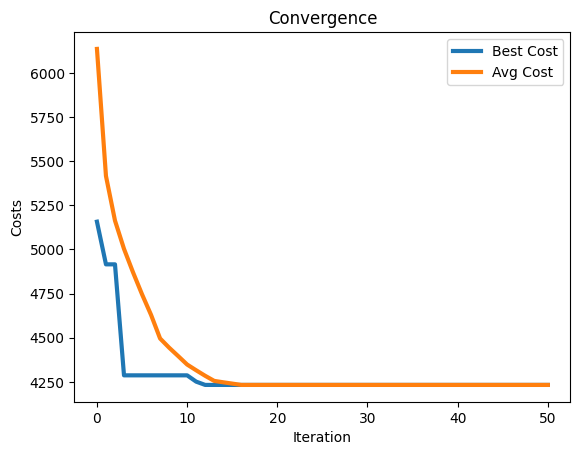

In [47]:
model = hubLocation()
maxIt = 50
nPop = 20
pc = 0.7
pm = 0.7
bestSolution, bestCosts, avgCosts, nfe = genetic_algorithm(model, maxIt, nPop, pc, pm)

# Plot the result
plt.plot(bestCosts, linewidth = 3, label = "Best Cost")
plt.plot(avgCosts, linewidth = 3, label = "Avg Cost")
plt.title("Convergence")
plt.xlabel("Iteration")
plt.ylabel('Costs')
plt.legend()
plt.show()

# No signifcant difference through results here, more like a better representation for solutions